In [165]:
import pandas as pd
import numpy as np
import statsmodels
from statsmodels.tsa.stattools import coint

import matplotlib.pyplot as plt
import seaborn as sns


import yfinance as yf

from backtesting import Backtest, Strategy
from backtesting.lib import crossover
from backtesting.test import SMA #,GOOG

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [166]:
#Download data
pairs = ['SHEL', 'BP']
data = yf.download(pairs, '2010-01-01')
data.index = pd.to_datetime(data.index)
data.head()

[*********************100%***********************]  2 of 2 completed


Price                      Adj Close                 Close             \
Ticker                            BP       SHEL         BP       SHEL   
Date                                                                    
2010-01-04 00:00:00+00:00  27.320095  28.982588  59.150002  62.349998   
2010-01-05 00:00:00+00:00  27.514097  29.015127  59.570000  62.419998   
2010-01-06 00:00:00+00:00  27.657278  28.778069  59.880001  61.910000   
2010-01-07 00:00:00+00:00  27.648041  28.638613  59.860001  61.610001   
2010-01-08 00:00:00+00:00  27.712700  28.596781  60.000000  61.520000   

Price                           High                   Low             \
Ticker                            BP       SHEL         BP       SHEL   
Date                                                                    
2010-01-04 00:00:00+00:00  59.450001  62.400002  59.080002  61.799999   
2010-01-05 00:00:00+00:00  59.900002  62.700001  59.310001  62.040001   
2010-01-06 00:00:00+00:00  59.919998  62.330002  59.340000  61.799999   
2010-01-07 00:00:00+00:00  60.000000  61.689999  59.689999  61.119999   
2010-01-08 00:00:00+00:00  60.060001  61.540001  59.669998  60.919998   

Price                           Open              Volume           
Ticker                            BP       SHEL       BP     SHEL  
Date                                                               
2010-01-04 00:00:00+00:00  59.299999  61.860001  3956100  1643003  
2010-01-05 00:00:00+00:00  59.650002  62.610001  4109600  1718458  
2010-01-06 00:00:00+00:00  59.520000  62.139999  6227900  3040554  
2010-01-07 00:00:00+00:00  59.919998  61.540001  4431300  1033089  
2010-01-08 00:00:00+00:00  59.790001  61.169998  3786100  1438017

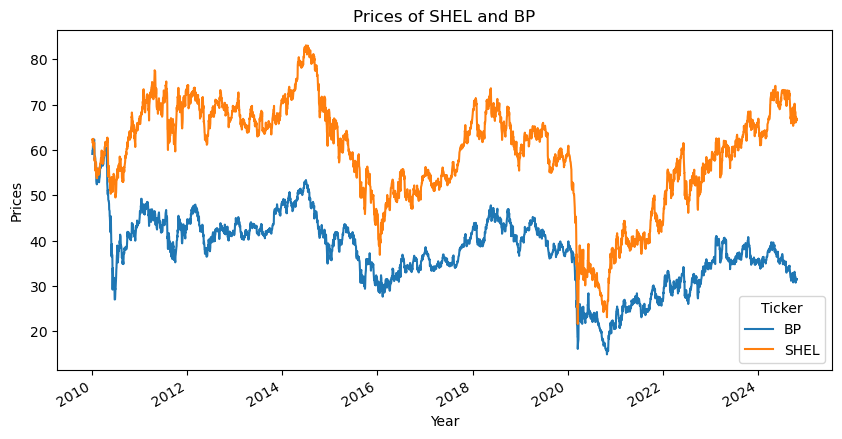

In [167]:
#Visualize data
data['Close'].plot(figsize=(10, 5))
plt.title('Prices of SHEL and BP')
plt.ylabel('Prices')
plt.xlabel('Year')
plt.show()

In [168]:
#Check for cointegration
#We use log-prices
SHEL = data['Close']['SHEL']
BP = data['Close']['BP']

SHEL_log = np.log(SHEL)
BP_log = np.log(BP)

coint_t, p_value, critical_values = coint(SHEL_log, BP_log)

# Output the results
print(f"P-value: {p_value}")
if p_value < 0.05:
    print('Pairs are cointegrated')
else:
    print('Pairs not cointegrated')

P-value: 0.05286584604056052
Pairs not cointegrated


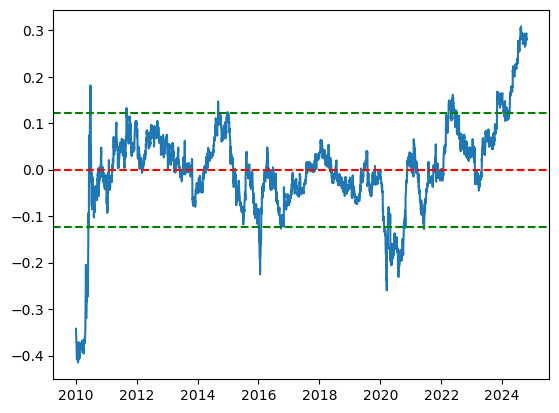

In [169]:
#Compute hedge ratio
import statsmodels.api as sm

# Add constant to BP for regression
X = sm.add_constant(BP_log)

#Fit linear model
model = sm.OLS(SHEL_log, X).fit()
beta = model.params[1]  # Hedge ratio

spread = SHEL_log - model.predict(X)
threshold = 1.5
plt.plot(spread)
plt.axhline(spread.mean(), linestyle='--', color='red')
plt.axhline(1.2 * spread.std(), linestyle='--', color='green')
plt.axhline(1.2 * -spread.std(), linestyle='--', color='green')

In [170]:
#Prepare data
SHEL = data.loc[:, ('Close', 'SHEL')]
BP = data.loc[:, ('Close', 'BP')]
ratio = (SHEL*beta) / BP

SHEL = SHEL.to_frame(name='SHEL')
BP = BP.to_frame(name='BP')
ratio = ratio.to_frame(name='Close')

df = pd.concat([ratio, SHEL, BP], axis=1)
df['Open'] = df['High'] = df['Low'] = df['Close']
df

,Close,SHEL,BP,Open,High,Low
Date,,,,,,
2010-01-04 00:00:00+00:00,0.925204,62.349998,59.150002,0.925204,0.925204,0.925204
2010-01-05 00:00:00+00:00,0.919712,62.419998,59.570000,0.919712,0.919712,0.919712
2010-01-06 00:00:00+00:00,0.907476,61.910000,59.880001,0.907476,0.907476,0.907476
2010-01-07 00:00:00+00:00,0.903380,61.610001,59.860001,0.903380,0.903380,0.903380
2010-01-08 00:00:00+00:00,0.899955,61.520000,60.000000,0.899955,0.899955,0.899955
...,...,...,...,...,...,...
2024-10-18 00:00:00+00:00,1.878147,67.040001,31.330000,1.878147,1.878147,1.878147
2024-10-21 00:00:00+00:00,1.870071,67.050003,31.469999,1.870071,1.870071,1.870071
2024-10-22 00:00:00+00:00,1.862445,67.010002,31.580000,1.862445,1.862445,1.862445


In [175]:
class CointegrationStrategy(Strategy):
    n = 5
    def init(self):
        self.asset_1 = self.data.df.SHEL
        self.asset_2 = self.data.df.BP

        self.spread = spread
        self.spread_mean = self.spread.mean()
        self.spread_std = self.spread.std()

        self.spread = self.I(lambda x: x, self.spread)

    def next(self):
        # Compute z-score to use as signal
        z_score = (self.spread[-1] - self.spread_mean) / self.spread_std
        
        
        if z_score > 1 and not self.position:  # Spread is much higher than mean
            self.sell()
            
        elif z_score < -1 and not self.position:  # Spread is much lower than mean
            self.buy() 
        
        elif abs(z_score) < 0.5:  # Spread has reverted back
            self.position.close()





In [176]:

bt = Backtest(df, CointegrationStrategy,
              cash=10000, commission=.002,
             exclusive_orders=True)

output = bt.run()
bt.plot(plot_volume=False)
output

Start                     2010-01-04 00:00...
End                       2024-10-24 00:00...
Duration                   5407 days 00:00:00
Exposure Time [%]                    68.48176
Equity Final [$]                  4031.647227
Equity Peak [$]                  10111.355952
Return [%]                         -59.683528
Buy & Hold Return [%]              101.278593
Return (Ann.) [%]                   -5.955809
Volatility (Ann.) [%]               47.152489
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -91.789076
Avg. Drawdown [%]                  -45.994736
Max. Drawdown Duration     5333 days 00:00:00
Avg. Drawdown Duration     2668 days 00:00:00
# Trades                                  146
Win Rate [%]                         58.90411
Best Trade [%]                       8.253179
Worst Trade [%]                    -45.790741
Avg. Trade [%]                    